In [1]:
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Embedding, Input, LSTM, Dense, Bidirectional, Concatenate, RepeatVector, Dot, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.activations import softmax

import keras.backend as K

Using TensorFlow backend.
/Users/aishwaryamalgonde/Aishwarya/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aishwaryamalgonde/Aishwarya/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aishwaryamalgonde/Aishwarya/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

In [2]:
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
NUM_SAMPLES = 1000

### Get input data

In [3]:
encoder_input = []

decoder_output = []
decoder_input = []

counter = 0
for line in open('data/spa-eng/spa.txt'):
    temp_line = line.split('\t')
    if not temp_line:
        continue
    
    input_ = temp_line[0].strip()
    translation = temp_line[1].strip()
    
    encoder_input.append(input_)
    
    decoder_input.append('<sos> ' + translation)
    decoder_output.append(translation + ' <eos>')
    
    counter += 1
    if counter >= NUM_SAMPLES:
        break
    
len(encoder_input), len(decoder_input), len(decoder_output)

(1000, 1000, 1000)

In [4]:
# decoder_output[:10]

### Tokenizing input data

In [5]:
## Tokenizing Encoder Data
en_tokenizer_ = Tokenizer(num_words=MAX_VOCAB_SIZE)
en_tokenizer_.fit_on_texts(encoder_input)

## Total number of unique words
en_word2ind = en_tokenizer_.word_index
print(len(en_word2ind))

en_sequences = en_tokenizer_.texts_to_sequences(encoder_input)

en_NUM_WORDS = min(len(en_word2ind) + 1, MAX_VOCAB_SIZE)
print(en_NUM_WORDS)

378
379


In [6]:
len(en_sequences), en_sequences[100]

(1000, [182])

In [7]:
dec_tokenizer_ = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
dec_tokenizer_.fit_on_texts(decoder_input + decoder_output)

## Total number of unique words
dec_word2ind = dec_tokenizer_.word_index
print(len(dec_word2ind))

dec_out_sequences = dec_tokenizer_.texts_to_sequences(decoder_output)
dec_inp_sequences = dec_tokenizer_.texts_to_sequences(decoder_input)

dec_NUM_WORDS = min(len(dec_word2ind) + 1, MAX_VOCAB_SIZE)
print(dec_NUM_WORDS)

1014
1015


In [8]:
(dec_out_sequences[0], decoder_output[0])

([121, 2], 'Ve. <eos>')

### Padding data

In [9]:
## getting max len
MAX_ENC_SEQ_LEN = max([len(s) for s in en_sequences])
print(MAX_ENC_SEQ_LEN)

en_sequences = pad_sequences(en_sequences, maxlen=MAX_ENC_SEQ_LEN) # default padding='pre'

3


In [10]:
en_sequences[998]

array([  0,  41, 242], dtype=int32)

In [11]:
## getting max len
MAX_DEC_SEQ_LEN = max([len(s) for s in dec_out_sequences])
print(MAX_DEC_SEQ_LEN)

dec_inp_sequences = pad_sequences(dec_inp_sequences, maxlen=MAX_DEC_SEQ_LEN, padding='post')
dec_out_sequences = pad_sequences(dec_out_sequences, maxlen=MAX_DEC_SEQ_LEN, padding='post')

7


In [12]:
dec_inp_sequences[0]

array([  1, 121,   0,   0,   0,   0,   0], dtype=int32)

### One-hoting the target outputs

In [13]:
### Need to one-hot the targets because cannot use sparse-categorical-crossentropy for list of outputs
one_hot_targets = np.zeros((len(dec_out_sequences), MAX_DEC_SEQ_LEN, dec_NUM_WORDS))

for i, seq in enumerate(dec_out_sequences):
    
    for j, word_ind in enumerate(seq):
        
        one_hot_targets[i, j, word_ind] = 1

In [14]:
one_hot_targets.shape

(1000, 7, 1015)

### Prepare embeddings

In [15]:
word2vec = {}
for line in open('glove.6B/glove.6B.{0}d.txt'.format(EMBEDDING_DIM)):
    temp = line.strip().split(' ')
    word = temp[0]
    arr = np.asarray(temp[1:], dtype='float16')
    word2vec[word] = arr

print(len(word2vec))

400000


In [16]:
# word2vec['is']

In [17]:
embedding_matrix = np.zeros((en_NUM_WORDS, EMBEDDING_DIM))
for k, i in en_word2ind.items():

    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(k)
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
print(embedding_matrix.shape)

(379, 50)


### Model

In [18]:
LATENT_DIM = 15
EN_LATENT_DIM = LATENT_DIM
DEC_LATENT_DIM = LATENT_DIM*2

Tx = MAX_ENC_SEQ_LEN
Ty = MAX_DEC_SEQ_LEN

In [19]:
### ENCODER ###
## create the embedding_layer
en_embedding_layer = Embedding(input_dim=en_NUM_WORDS, output_dim=EMBEDDING_DIM, weights=[embedding_matrix])

en_input = Input(shape=(MAX_ENC_SEQ_LEN, ))
x = en_embedding_layer(en_input)

en_lstm = Bidirectional(LSTM(EN_LATENT_DIM, return_sequences=True)) # return_state=True
en_o = en_lstm(x)#, initial_state = [initial_h, initial_c])

In [20]:
def softmax_axis1(x):
    return softmax(x, axis=1)

In [21]:
### Concatenating ENCODER output and DECODER initial state
attn_repeat_layer = RepeatVector(Tx)
attn_concat_layer = Concatenate(axis=-1)

attn_nn_dense1 = Dense(10, activation='tanh')
attn_nn_dense2 = Dense(1, activation=softmax_axis1)

attn_dot = Dot(axes=1)

def one_step_attn(h, st_0):
    
    st_0 = attn_repeat_layer(st_0)
    x = attn_concat_layer([h, st_0])
    
    x = attn_nn_dense1(x)
    alphas = attn_nn_dense2(x)
    
    context = attn_dot([alphas, h])
    
    return context, alphas

In [22]:
### DECODER ###
dec_embedding_layer = Embedding(input_dim=dec_NUM_WORDS, output_dim=EMBEDDING_DIM)#, weights=[embedding_matrix])

dec_input = Input(shape=(MAX_DEC_SEQ_LEN, ))
dec_input_x = dec_embedding_layer(dec_input)

dec_lstm = LSTM(DEC_LATENT_DIM, return_state=True)#, return_sequences=True)
dec_dense = Dense(dec_NUM_WORDS, activation='softmax')

initial_h = Input(shape=(DEC_LATENT_DIM, ))
initial_c = Input(shape=(DEC_LATENT_DIM, ))

context_concat = Concatenate(axis=2)

outputs = []
s = initial_h
c = initial_c
for t in range(Ty):
    context, _ = one_step_attn(en_o, s)
    
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(dec_input_x)
    
    decoder_lstm_input = context_concat([context, xt])
    
    y, s, c = dec_lstm(decoder_lstm_input, initial_state=[s, c])
    dec_output = dec_dense(y)
    
    outputs.append(dec_output)

In [23]:
# READ
# 'outputs' is a list of length Ty
# each element of shape (batch_size-N x output vocab size-D)
# if we stack all outputs into 1 tensor
# it would be of shape (Ty x N x D)
# we want output as N x Ty x D

def stack_and_transpose(x):
    x = K.stack(x)                                   # it would be of shape (Ty x N x D)
    x = K.permute_dimensions(x, pattern=(1,0,2))     # we want output as N x Ty x D
    return x

stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [24]:
model = Model([en_input, dec_input, initial_h, initial_c], outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

In [25]:
z = np.zeros((NUM_SAMPLES, DEC_LATENT_DIM))
model.fit([en_sequences, dec_inp_sequences, z, z],
          one_hot_targets,
          epochs=20,
          batch_size=5,
          validation_split=VALIDATION_SPLIT)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 8s 10ms/step - loss: 2.5229 - acc: 0.6584 - val_loss: 2.4348 - val_acc: 0.6764
Epoch 2/20
800/800 [==============================] - 3s 4ms/step - loss: 1.7639 - acc: 0.7279 - val_loss: 2.6198 - val_acc: 0.6764
Epoch 3/20
800/800 [==============================] - 2s 3ms/step - loss: 1.6557 - acc: 0.7354 - val_loss: 2.6679 - val_acc: 0.6664
Epoch 4/20
800/800 [==============================] - 2s 3ms/step - loss: 1.5951 - acc: 0.7427 - val_loss: 2.7627 - val_acc: 0.6650
Epoch 5/20
800/800 [==============================] - 2s 3ms/step - loss: 1.5554 - acc: 0.7420 - val_loss: 2.7776 - val_acc: 0.6564
Epoch 6/20
800/800 [==============================] - 2s 3ms/step - loss: 1.5111 - acc: 0.7448 - val_loss: 2.6623 - val_acc: 0.6729
Epoch 7/20
800/800 [==============================] - 2s 3ms/step -

### Making the predictions

In [33]:
encoder_model = Model(en_input, en_o)

dec_input_single = Input(shape=(1, ))
dec_input_single_x = dec_embedding_layer(dec_input_single)

en_output_as_input = Input(shape=(MAX_ENC_SEQ_LEN, DEC_LATENT_DIM,))
context, alphas_pred = one_step_attn(en_output_as_input, initial_h)

dec_input = context_concat([context, dec_input_single_x])

dec_op, dec_h, dec_c = dec_lstm(dec_input, initial_state = [initial_h, initial_c])
dec_output = dec_dense(dec_op)

decoder_model = Model([en_output_as_input, dec_input_single, initial_h, initial_c], [dec_output, dec_h, dec_c])
decoder_model_attn = Model([en_output_as_input, dec_input_single, initial_h, initial_c], alphas_pred)

In [27]:
dec_ind2word = {v:k for k, v in dec_word2ind.items()}
len(dec_ind2word)

1014

In [28]:
en_ind2word = {v:k for k, v in en_word2ind.items()}
len(en_ind2word)

378

In [83]:
def translate():
    
    i = np.random.choice(len(en_sequences))
    input_seq = en_sequences[i:i+1]
    print('Input seq:', input_seq)
    input_text = ' '.join([en_ind2word.get(w) for w in input_seq[0] if w>0])
    print('Input seq:', input_text)
    
    en_output_pred = encoder_model.predict(input_seq)
    h = np.zeros((1, DEC_LATENT_DIM))
    c = np.zeros((1, DEC_LATENT_DIM))
    
    sos = dec_word2ind['<sos>']
    dec_start = np.array([[sos]])
    
    eos = dec_word2ind['<eos>']
    
    generated_output = []
    all_alphas = []
    
    for _ in range(MAX_DEC_SEQ_LEN):
        p, h, c = decoder_model.predict([en_output_pred, dec_start, h, c])
        gen_alphas = decoder_model_attn.predict([en_output_pred, dec_start, h, c])
        
        # probabilties
        probs = p[0]
        index = np.argmax(probs)
        
        # if probabilty of <sos> is high then it prints a warning
        if index == sos:
            print('wtf')
        
        if index == eos:
            break

        generated_output.append(dec_ind2word.get(index, '<WTF> %s'% index))
        dec_start[0][0] = index
        all_alphas.append(gen_alphas)
    
    return ' '.join(generated_output), all_alphas, input_text

In [105]:
output_text, all_alphas, input_text = translate()
print('Output text:', output_text)

Input seq: [[ 1 39  8]]
Input seq: i saw you
Output text: me he mudado.


### Displaying Attention weights

In [106]:
b = np.concatenate(all_alphas, axis=2)[0]
b.shape, b

((3, 3), array([[0.23246102, 0.3741106 , 0.2541163 ],
        [0.6331667 , 0.32503998, 0.58894074],
        [0.13437237, 0.30084944, 0.15694298]], dtype=float32))

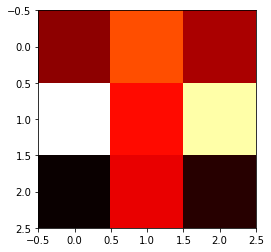

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# a = np.random.random((16, 16))
plt.imshow(b, cmap='hot', interpolation='nearest')
plt.show()

<Figure size 3600x3600 with 0 Axes>

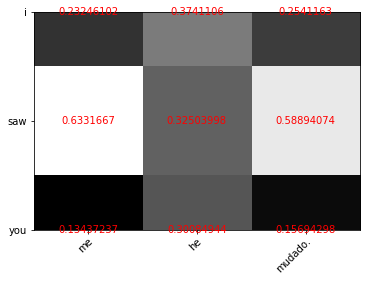

<Figure size 3600x3600 with 0 Axes>

In [118]:
my_xticks = output_text.split(' ')
my_yticks = input_text.split(' ')
# plt.xticks(my_xticks)

fig, ax = plt.subplots()
im = ax.imshow(b, cmap='gray')

# We want to show all ticks...
ax.set_xticks(np.arange(len(my_xticks)))
ax.set_yticks(np.arange(len(my_yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(my_xticks)
ax.set_yticklabels(my_yticks)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# plt.setp(ax.get_yticklabels(),)

# Loop over data dimensions and create text annotations.
for i in range(len(my_yticks)):
    for j in range(len(my_xticks)):
        text = ax.text(j, i, b[i, j],
                       ha="center", va="center", color='r')
plt.figure(figsize=(50,50))

In [92]:
(a.shape)

(16, 16)

In [157]:
def calc_storage(file_size):
    block_size = 4096

    full_blocks = file_size//block_size
    p = file_size%block_size
    
    return block_size * (full_blocks + min(1, p))

In [162]:
print(calc_storage(1))
print(calc_storage(4096))
print(calc_storage(4097))
print(calc_storage(6000))

4096
4096
8192
8192
